# Mean-variance optimization

In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import quantstats as qs
qs.extend_pandas()

In [158]:
prefix_name = 'SIPP5_'

In [159]:
def generate_performance_metrics (prices_pivot = None, prefix_name = None, file_text = None, benchmark = 'SPY', title = 'Strategy Tearsheet', weights = None):
    returns = np.log(prices_pivot/prices_pivot.shift(1))
    agg_returns = returns * weights
    portfolio_return = agg_returns.sum(axis=1)
    portfolio_return.name = 'Close'
    portfolio_return.index = pd.to_datetime(portfolio_return.index)
    qs.reports.html(returns = portfolio_return, benchmark = benchmark, output = prefix_name + file_text + '.html', title= prefix_name+ title)

## Downloading data

In [160]:
# ALL FILES
path = r'C:\Users\Ferhat\Python Code\Github\Portfolio_Optimisation\PortfolioOptimisation\fund_series'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent


In [161]:
iterator = zip(np.arange(len(all_files)).tolist(), all_files)
file_list = dict(iterator)
file_list

{0: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Allianz Technology Trust Ord daily.csv',
 1: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Fundsmith Equity I Inc daily.csv',
 2: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\GS India Equity R Inc GBP daily.csv',
 3: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\HgCapital Trust Ord daily.csv',
 4: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares Physical Gold ETC GBP.csv',
 5: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares Physical Silver ETC GBP.csv',
 6: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares £ Corp Bond 0-5yr ETF GBP Dist.csv',


In [162]:
# SOME FILES
path = r'C:\Users\Ferhat\Python Code\Github\Portfolio_Optimisation\PortfolioOptimisation\fund_series'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
#sub_files = all_files[1, 3, 4, 7, 8, 13, 14]

indices = [14, 3, 8, 9, 13, 12]
sub_files = []

for index in indices:
    sub_files.append(file_list[index])

df_from_each_file = (pd.read_csv(f, index_col=False) for f in sub_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
sub_files

['C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Scottish Mortgage Ord daily.csv',
 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\HgCapital Trust Ord daily.csv',
 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\JPMorgan China Growth & Income Ord daily.csv',
 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Montanaro European Smaller Ord daily.csv',
 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Rathbone Global Opportunities S Acc daily.csv',
 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\PIMCO GIS Glb Bd Instl GBPH Acc.csv']

In [163]:
concatenated_df.drop([ 'High', 'Low', 'Open', 'Volume'], axis=1, inplace=True)
concatenated_df['Close'] = concatenated_df['Close'].fillna(concatenated_df['NAV'])
concatenated_df.drop(['NAV'], axis=1, inplace=True)
concatenated_df_pivot = concatenated_df.pivot(columns='Name', values='Close', index='Date')
concatenated_df_pivot = concatenated_df_pivot.sort_values(by="Date", key=pd.to_datetime)
concatenated_df_pivot = concatenated_df_pivot.dropna()

<AxesSubplot:xlabel='Date'>

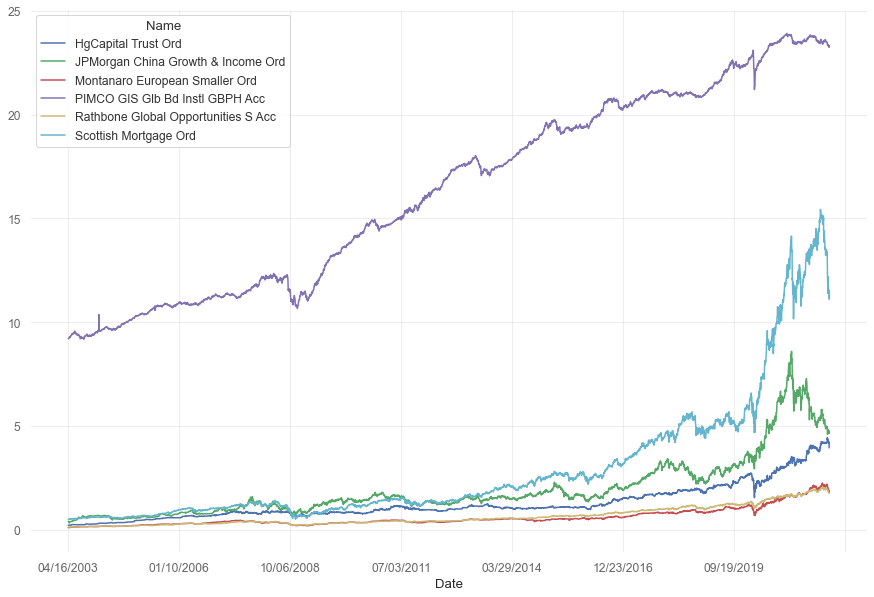

In [164]:
concatenated_df_pivot.plot(figsize=(15,10))

## Calculating the covariance matrix

In [165]:
import pypfopt
pypfopt.__version__

'1.5.1'

In [166]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(concatenated_df_pivot, frequency=252)
sample_cov

Name,HgCapital Trust Ord,JPMorgan China Growth & Income Ord,Montanaro European Smaller Ord,PIMCO GIS Glb Bd Instl GBPH Acc,Rathbone Global Opportunities S Acc,Scottish Mortgage Ord
Name,,,,,,
HgCapital Trust Ord,0.030686,0.008812,0.008608,0.000316,0.003575,0.008773
JPMorgan China Growth & Income Ord,0.008812,0.057869,0.012946,0.000152,0.011791,0.022607
Montanaro European Smaller Ord,0.008608,0.012946,0.022841,0.000373,0.007701,0.014664
PIMCO GIS Glb Bd Instl GBPH Acc,0.000316,0.000152,0.000373,0.001196,0.000307,0.000164
Rathbone Global Opportunities S Acc,0.003575,0.011791,0.007701,0.000307,0.016741,0.011938
Scottish Mortgage Ord,0.008773,0.022607,0.014664,0.000164,0.011938,0.042350


<AxesSubplot:>

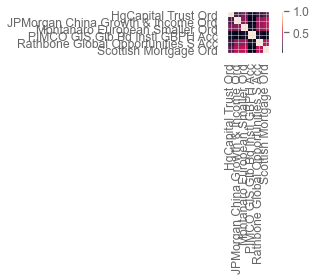

In [167]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

## Return estimation

In [168]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(concatenated_df_pivot)
mu

Name
HgCapital Trust Ord                    0.096846
JPMorgan China Growth & Income Ord     0.164380
Montanaro European Smaller Ord         0.104892
PIMCO GIS Glb Bd Instl GBPH Acc        0.023172
Rathbone Global Opportunities S Acc    0.085822
Scottish Mortgage Ord                  0.147079
Name: mkt, dtype: float64

## Manual Weights

In [169]:
concatenated_df['Name'].unique()

array(['Scottish Mortgage Ord', 'HgCapital Trust Ord',
       'JPMorgan China Growth & Income Ord',
       'Montanaro European Smaller Ord',
       'Rathbone Global Opportunities S Acc',
       'PIMCO GIS Glb Bd Instl GBPH Acc'], dtype=object)

In [170]:
initial_weights = [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]
unique_fund_names = concatenated_df['Name'].unique()

iterator = zip(unique_fund_names.tolist(), initial_weights)
comb_weights = dict(iterator)
comb_weights

{'Scottish Mortgage Ord': 0.2,
 'HgCapital Trust Ord': 0.2,
 'JPMorgan China Growth & Income Ord': 0.2,
 'Montanaro European Smaller Ord': 0.2,
 'Rathbone Global Opportunities S Acc': 0.1,
 'PIMCO GIS Glb Bd Instl GBPH Acc': 0.1}

In [171]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'manual_weights', prefix_name = prefix_name, file_text = 'manual_weights', weights = comb_weights)

## Long/short min variance

In [172]:
from pypfopt import EfficientFrontier

In [173]:
S = risk_models.CovarianceShrinkage(concatenated_df_pivot).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(0, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('HgCapital Trust Ord', 0.02552),
             ('JPMorgan China Growth & Income Ord', 0.00326),
             ('Montanaro European Smaller Ord', 0.01876),
             ('PIMCO GIS Glb Bd Instl GBPH Acc', 0.89704),
             ('Rathbone Global Opportunities S Acc', 0.05212),
             ('Scottish Mortgage Ord', 0.00331)])

In [174]:
ef.portfolio_performance(verbose=True);

Annual volatility: 3.8%


In [175]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'min_variance', prefix_name = prefix_name, file_text = 'min_variance', weights = weights)

## Max Sharpe

In [176]:
S = risk_models.CovarianceShrinkage(concatenated_df_pivot).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('HgCapital Trust Ord', 0.17369),
             ('JPMorgan China Growth & Income Ord', 0.17479),
             ('Montanaro European Smaller Ord', 0.17402),
             ('PIMCO GIS Glb Bd Instl GBPH Acc', 0.13035),
             ('Rathbone Global Opportunities S Acc', 0.17236),
             ('Scottish Mortgage Ord', 0.17479)])

In [177]:
ef.portfolio_performance(verbose=True);

Expected annual return: 10.7%
Annual volatility: 10.9%
Sharpe Ratio: 0.80


In [178]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_sharpe', prefix_name = prefix_name, file_text = 'max_sharpe', weights = weights)

## Maximise return for a given risk, with L2 regularisation

In [179]:
ef = EfficientFrontier(mu, S)
ef.efficient_risk(target_volatility=0.12)
weights = ef.clean_weights()
weights

OrderedDict([('HgCapital Trust Ord', 0.19042),
             ('JPMorgan China Growth & Income Ord', 0.1942),
             ('Montanaro European Smaller Ord', 0.19156),
             ('PIMCO GIS Glb Bd Instl GBPH Acc', 0.04367),
             ('Rathbone Global Opportunities S Acc', 0.18598),
             ('Scottish Mortgage Ord', 0.19416)])

In [180]:
ef.portfolio_performance(verbose=True)

Expected annual return: 11.6%
Annual volatility: 12.0%
Sharpe Ratio: 0.80


(0.1159880737515889, 0.11999999962417064, 0.7999006171017919)

In [181]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_return_given_risk', prefix_name = prefix_name, file_text = 'max_return_given_risk', weights = weights)

## L2 Regularisation

In [182]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('HgCapital Trust Ord', 0.12436),
             ('JPMorgan China Growth & Income Ord', 0.35354),
             ('Montanaro European Smaller Ord', 0.14886),
             ('PIMCO GIS Glb Bd Instl GBPH Acc', 0.0),
             ('Rathbone Global Opportunities S Acc', 0.07231),
             ('Scottish Mortgage Ord', 0.30092)])

In [183]:
ef.portfolio_performance(verbose=True)

Expected annual return: 13.6%
Annual volatility: 15.0%
Sharpe Ratio: 0.77


(0.13623871737875662, 0.14999999978990353, 0.7749247836104372)

In [184]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_return_l2_reg', prefix_name = prefix_name, file_text = 'max_return_L2_reg', weights = weights)

## Efficient semi-variance optimization

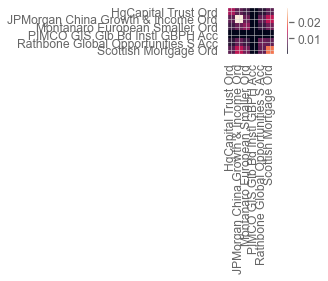

In [185]:
semicov = risk_models.semicovariance(concatenated_df_pivot, benchmark=0)
plotting.plot_covariance(semicov);

In [186]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.06)
weights = ef.clean_weights()
weights

OrderedDict([('HgCapital Trust Ord', 0.07678),
             ('JPMorgan China Growth & Income Ord', 0.07554),
             ('Montanaro European Smaller Ord', 0.1109),
             ('PIMCO GIS Glb Bd Instl GBPH Acc', 0.61986),
             ('Rathbone Global Opportunities S Acc', 0.04971),
             ('Scottish Mortgage Ord', 0.06721)])

In [187]:
ef.portfolio_performance(verbose=True);

Expected annual return: 6.0%
Annual volatility: 4.3%
Sharpe Ratio: 0.92


In [188]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'semi_var_opt', prefix_name = prefix_name, file_text = 'semi_var_opt', weights = weights)

## Efficient CVaR optimization

In [189]:
returns = expected_returns.returns_from_prices(concatenated_df_pivot).dropna()
returns.head()

Name,HgCapital Trust Ord,JPMorgan China Growth & Income Ord,Montanaro European Smaller Ord,PIMCO GIS Glb Bd Instl GBPH Acc,Rathbone Global Opportunities S Acc,Scottish Mortgage Ord
Date,,,,,,
04/17/2003,0.0,-0.012195,-0.000913,0.0,-0.010186,-0.001953
04/18/2003,0.0,0.000000,0.000000,0.0,0.000000,0.000000
04/19/2003,0.0,0.000000,0.000000,0.0,0.000000,0.000000
04/20/2003,0.0,0.000000,0.000000,0.0,0.000000,0.000000
04/21/2003,0.0,0.000000,0.000000,0.0,0.000000,0.000000


In [190]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 10.7%
Annual volatility: 10.9%
Sharpe Ratio: 0.80


## Plotting - Unconstrained

In [191]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 5.7%
Annual volatility: 5.2%
Sharpe Ratio: 0.72


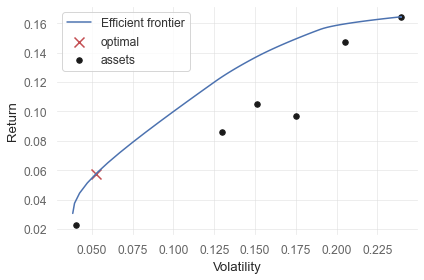

In [192]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)